In [1]:
import sys
sys.path.append("../code/")
import util_ElasticNet, lib_LinearAlgebra, util_hdf5, lib_ElasticNet, lib_Checker, util_Stats
import tensorflow as tf
import numpy as np
import pandas as pd
import h5py, yaml, functools
import matplotlib.pyplot as plt
from importlib import reload
lib_LinearAlgebra = reload(lib_LinearAlgebra)
util_ElasticNet = reload(util_ElasticNet)
util_hdf5 = reload(util_hdf5)
lib_ElasticNet = reload(lib_ElasticNet)
lib_Checker = reload(lib_Checker)
util_Stats = reload(util_Stats)
import util_hdf5
import logging, sys
import seaborn as sns
logging.basicConfig(
    level = logging.INFO, 
    stream = sys.stderr,
#     filename = logfile,
    format = '%(asctime)s  %(message)s',
    datefmt = '%Y-%m-%d %I:%M:%S %p'
)

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[1], 'GPU')

# Overview

We've trained a sequence of elastic net models (with different $\lambda$'s and $\alpha$'s) and here we'd like to compute the PTRS on held out Britishs and other populations. 

So, for each $\lambda$ and $\alpha$ pair, we have one PTRS nsample x ntrait matrix. 
In total, we will have $$nsample \times (ntrait = 17) \times (nlambda = 50) \times (nalpha = 3)$$ PTRS tensor for each population.

# Load predicted expression 

First load British and then load other populations.

In [2]:
population = 'British'

# set path to British data
hdf5_british = f'/vol/bmd/yanyul/UKB/predicted_expression_tf2/ukb_imp_x_ctimp_Whole_Blood_{population}.hdf5'

# data scheme specifying which are traits and covariates
scheme_yaml = '../misc_files/data_scheme.yaml'

# loading names of traits/covariates
# the order is matched with the data being loaded
feature_dic = util_hdf5.read_yaml(scheme_yaml)
with h5py.File(hdf5_british, 'r') as f:
    features = f['columns_y'][:].astype('str')
    sample_size = f['y'].shape[0]
    y = f['y'][:]
covar_indice = np.where(np.isin(features, feature_dic['covar_names']))[0]
trait_indice = np.where(np.isin(features, feature_dic['outcome_names']))[0]

# load data_scheme for training
batch_size = 2 ** 12
print(f'batch_size in British set is {batch_size}')
data_scheme, sample_size = util_hdf5.build_data_scheme(
    hdf5_british, 
    scheme_yaml, 
    batch_size = batch_size, 
    inv_norm_y = True
)

# set validation and test set as the first and second batch
dataset_valid = data_scheme.dataset.take(1)
data_scheme.dataset = data_scheme.dataset.skip(1)
dataset_test = data_scheme.dataset.take(1)
data_scheme.dataset = data_scheme.dataset.skip(1)
dataset_insample = data_scheme.dataset.take(1)

batch_size in British set is 4096


Load other populations.

In [3]:
test_datasets = {
    'British_validation': dataset_valid,
    'British_test': dataset_test,
    'British_insample': dataset_insample,
    'Chinese': None,
    'Indian': None,
    'African': None
}
batch_size_here = 8096
for i in test_datasets.keys():
    if 'British' not in i:
        filename = f'/vol/bmd/yanyul/UKB/predicted_expression_tf2/ukb_imp_x_ctimp_Whole_Blood_{i}.hdf5'
        data_scheme, sample_size = util_hdf5.build_data_scheme(
            filename, 
            scheme_yaml, 
            batch_size = batch_size_here, 
            inv_norm_y = True
        )
        test_datasets[i] = data_scheme.dataset

# Load models

In [4]:
alpha_list = [0.1, 0.5, 0.9]
model_list = {}
for alpha in alpha_list:
    filename = f'/vol/bmd/yanyul/UKB/ptrs-tf/models/elastic_net_alpha_{alpha}_British.hdf5'
    model_list[alpha] = lib_LinearAlgebra.ElasticNetEstimator('', None, minimal_load = True)
    model_list[alpha].minimal_load(filename)

In [5]:
model_list[0.1].lambda_seq

[array([2.28699251e+01, 1.72510590e+01, 1.30126809e+01, 9.81562137e+00,
        7.40404102e+00, 5.58495702e+00, 4.21280012e+00, 3.17776569e+00,
        2.39702681e+00, 1.80810609e+00, 1.36387613e+00, 1.02878814e+00,
        7.76027240e-01, 5.85366662e-01, 4.41549099e-01, 3.33065786e-01,
        2.51235520e-01, 1.89509969e-01, 1.42949644e-01, 1.07828632e-01,
        8.13364317e-02, 6.13530467e-02, 4.62793396e-02, 3.49090614e-02,
        2.63323240e-02, 1.98627881e-02, 1.49827395e-02, 1.13016602e-02,
        8.52497797e-03, 6.43049321e-03, 4.85059822e-03, 3.65886446e-03,
        2.75992538e-03, 2.08184484e-03, 1.57036055e-03, 1.18454182e-03,
        8.93514110e-04, 6.73988418e-04, 5.08397554e-04, 3.83490377e-04,
        2.89271395e-04, 2.18200885e-04, 1.64591547e-04, 1.24153380e-04,
        9.36503844e-05, 7.06416091e-05, 5.32858137e-05, 4.01941289e-05,
        3.03189139e-05, 2.28699207e-05]),
 array([1.67107535e+01, 1.26051220e+01, 9.50819482e+00, 7.17214548e+00,
        5.41003543e+00

# Calculate PTRS 

In [6]:
out = model_list[0.1].predict_x(test_datasets['British_validation'], model_list[0.1].beta_hat_path)

(4096, 17, 50)


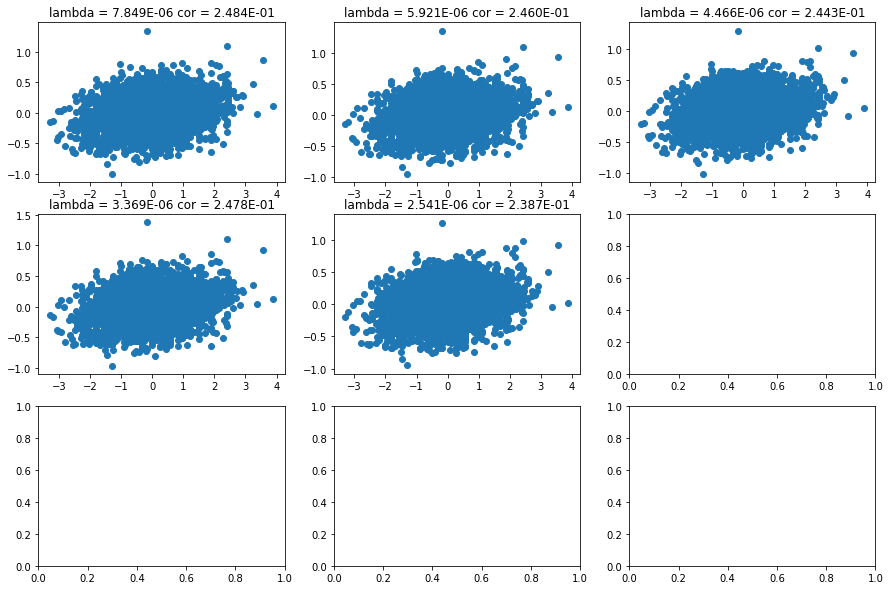

In [7]:
# out = o1
fig, aes = plt.subplots(nrows = 3, ncols = 3, figsize = (15, 10))
seq = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 16, 19]
for i in range(3):
    for j in range(3):
        idx = seq[(i * 3 + j)] + 45
        if idx < len(model_list[alpha].lambda_seq[0]):
            for k in range(1):
                aes[i][j].scatter(out['y'][:,k], out['y_pred_from_x'][:, k, idx])
            aes[i][j].set_title(
                'lambda = ' + "{:.3E} cor = {:.3E}".format(
                    model_list[alpha].lambda_seq[0][idx], 
                    np.corrcoef(out['y'][:, 0], out['y_pred_from_x'][:, 0, idx])[0,1]
                ) # + '\n' +
#                 'lambda = ' + "{:.3E} cor = {:.3E}".format(
#                     model_list[alpha].lambda_seq[1][idx], 
#                     np.corrcoef(out['y'][:, 1], out['y_pred_from_x'][:, 1, idx])[0,1]
#                 )
            )

# Calculate partial R2

In [8]:
partial_r2 = {}
for alpha in alpha_list:
    partial_r2[alpha] = {}
    model_i = model_list[alpha]
    for i in test_datasets.keys():
        dataset = test_datasets[i]
        for ele in dataset:
            x, y = model_i.data_scheme.get_data_matrix(ele)
            covar = x[:, -len(model_i.data_scheme.covariate_indice) :]
            print('alpha = {}, trait = {}, ncol(covar) = {}'.format(alpha, i, covar.shape[1]))
        out = model_i.predict_x(dataset, model_i.beta_hat_path)
        partial_r2[alpha][i] = util_Stats.quick_partial_r2(covar, out['y'], out['y_pred_from_x'])

alpha = 0.1, trait = British_validation, ncol(covar) = 25
(4096, 17, 50)
(26, 26)


../code/util_Stats.py:82: RuntimeWarning: invalid value encountered in true_divide
  partial_r2 = partial_r2_nomi / partial_r2_deno


alpha = 0.1, trait = British_test, ncol(covar) = 25
(4096, 17, 50)
(26, 26)
alpha = 0.1, trait = British_insample, ncol(covar) = 25
(4096, 17, 50)
(26, 26)
alpha = 0.1, trait = Chinese, ncol(covar) = 25
(1326, 17, 50)
(26, 26)
alpha = 0.1, trait = Indian, ncol(covar) = 25
(4789, 17, 50)
(26, 26)
alpha = 0.1, trait = African, ncol(covar) = 25
(2835, 17, 50)
(26, 26)
alpha = 0.5, trait = British_validation, ncol(covar) = 25
(4096, 17, 50)
(26, 26)
alpha = 0.5, trait = British_test, ncol(covar) = 25
(4096, 17, 50)
(26, 26)
alpha = 0.5, trait = British_insample, ncol(covar) = 25
(4096, 17, 50)
(26, 26)
alpha = 0.5, trait = Chinese, ncol(covar) = 25
(1326, 17, 50)
(26, 26)
alpha = 0.5, trait = Indian, ncol(covar) = 25
(4789, 17, 50)
(26, 26)
alpha = 0.5, trait = African, ncol(covar) = 25
(2835, 17, 50)
(26, 26)
alpha = 0.9, trait = British_validation, ncol(covar) = 25
(4096, 17, 50)
(26, 26)
alpha = 0.9, trait = British_test, ncol(covar) = 25
(4096, 17, 50)
(26, 26)
alpha = 0.9, trait = Bri

In [9]:
def _pr2_format(ele, features, name, alpha, lambda_):
    nlambda = lambda_.shape[1]
    ntrait = lambda_.shape[0]
    ele_seq = np.reshape(ele, (nlambda * ntrait), order = 'C')
    lambda_seq = np.reshape(lambda_, (nlambda * ntrait), order = 'C')
    f_seq = np.repeat(features, nlambda)
    return pd.DataFrame({'partial_r2': ele_seq, 'trait': f_seq, 'sample': name, 'alpha': alpha, 'lambda': lambda_seq})
df = pd.DataFrame({'partial_r2': [], 'trait': [], 'sample': [], 'alpha': [], 'lambda': []})
for alpha in alpha_list:
    model_i = model_list[alpha]
    lambda_i = np.array(model_i.lambda_seq)
    for i in partial_r2[alpha].keys():
        df = pd.concat((df, _pr2_format(partial_r2[alpha][i], features[trait_indice], i, alpha, lambda_i)))

In [10]:
df.to_csv('/vol/bmd/yanyul/UKB/ptrs-tf/models/partial_r2-elastic_net_British.tsv', sep = '\t', index = False)